In [1]:
from fastai2.vision.all import *
from siren import siren_model

In [58]:
import kornia

laplace_filter = partial(kornia.filters.laplacian, kernel_size=3)
gradient_filter = kornia.filters.sobel

def visualize_filter(image:TensorImage, filter_func):
    filt = filter_func(image.unsqueeze(0))
    # Normalizing to [0, 1] range
    filt -= filt.min()
    filt /= filt.max()
    plt.imshow(kornia.tensor_to_image(filt[0]))
    plt.axis(False)
    plt.show()
    
#Helper function
def decode_prediction(learner, inp, size=256):
    y_hat = learn.model.siren(inp.cuda())
    return TensorImage(y_hat.transpose(0, 1).reshape(3, size, size))

# Visualizing the original image

In [3]:
pipe = Pipeline([PILImage.create, ToTensor, IntToFloatTensor, Resize(256)])
image = pipe("Samples/yorkshire_terrier_9.jpg")

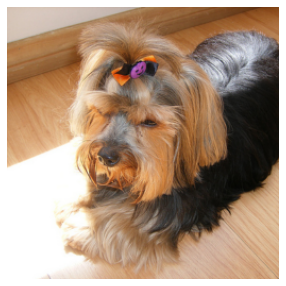

In [4]:
image.show();

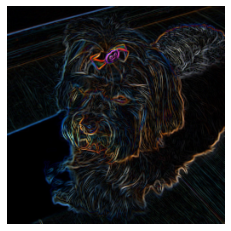

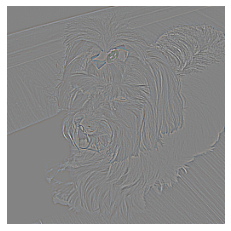

In [5]:
visualize_filter(image, gradient_filter)
visualize_filter(image, laplace_filter)

# Preparing the dataset

The first step is to reshape the image, so that each pixel will be a training example

In [6]:
filt = gradient_filter(image.unsqueeze(0))
# Normalizing to [0, 1] range
filt -= filt.min()
filt /= filt.max()

In [7]:
filt.shape

torch.Size([1, 3, 256, 256])

In [14]:
window_size = (32, 32)
patches = kornia.contrib.extract_tensor_patches(filt, window_size, stride=16)
patches.shape

torch.Size([1, 225, 3, 32, 32])

In [23]:
y = patches.squeeze()
y.shape

torch.Size([225, 3, 32, 32])

Then we create the coordinates that will be the input. According to the paper, they should be in the range [-1, 1], so we use meshgrid to create the coordinate pair (u, v) easily. In this case, the point (0, 0) represents the center of the image.

In [22]:
g0, g1 = torch.meshgrid([torch.arange(-1, 1, step=2/256), torch.arange(-1, 1, step=2/256)])
x = torch.cat([g0.unsqueeze(0), g1.unsqueeze(0)], dim=0)
x = x.float()
x = kornia.contrib.extract_tensor_patches(x.unsqueeze(0), window_size, stride=16)
x = x.squeeze()
x.shape

torch.Size([225, 2, 32, 32])

Now creating the dataset (image coordinates) -> (image pixel)

In [31]:
from torch.utils.data import TensorDataset, random_split
dset = TensorDataset(x.cuda(), y.cuda())

Random splitting the pixels so 20% of them are used for validation

In [32]:
val_pct = 0.2
val_len = int(len(dset)*val_pct)
lengths = [len(dset)-val_len, val_len]
train_dset, val_dset = random_split(dset, lengths)

In [77]:
dls = DataLoaders(DataLoader(train_dset, bs=128), DataLoader(val_dset, bs=64))

# Creating the model, optimizer and loss

In [98]:
class ReshapingModel(nn.Module):
    def __init__(self, siren, window_size):
        super().__init__()
        self.siren = siren
        self.window_size = window_size
    def forward(self, x):
        x = x.transpose(1, -1).reshape(-1, 2)
        out = self.siren(x)
        out = out.reshape(-1, *self.window_size, 3).transpose(1, -1)
        return out

In [160]:
def gradient_loss(pred, targ):
    pred = gradient_filter(pred)
    return mse(pred, targ)

In [161]:
mdl = ReshapingModel(siren_model([2, 256, 128, 64, 32, 3]), window_size)

learn = Learner(dls, 
    mdl.cuda(), 
    loss_func=gradient_loss,
    opt_func=ranger
    )

In [168]:
learn.model

ReshapingModel(
  (siren): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Siren(w0=30)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Siren(w0=1)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Siren(w0=1)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Siren(w0=1)
    )
    (4): Sequential(
      (0): Linear(in_features=32, out_features=3, bias=True)
      (1): Siren(w0=1)
    )
  )
)

# Starting the training

In [162]:
learn.fit_flat_cos(300, lr=1e-2)

epoch,train_loss,valid_loss,time
0,0.049576,0.048898,00:00
1,0.049485,0.048738,00:00
2,0.049394,0.046763,00:00
3,0.047851,0.036991,00:00
4,0.044500,0.028530,00:00
5,0.040764,0.030398,00:00
6,0.038252,0.022154,00:00
7,0.035340,0.017623,00:00
8,0.032637,0.018685,00:00
9,0.030503,0.014643,00:00


Visualizing the results of the training. Notice that the colors are wrong, but the gradients are correct (next images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


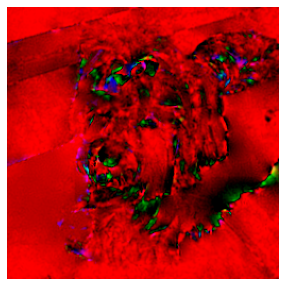

In [164]:
resol = 256 # Resolution
g0, g1 = torch.meshgrid([torch.arange(-1, 1, step=2/resol), torch.arange(-1, 1, step=2/resol)])
x_decoding = torch.cat([g0.flatten().unsqueeze(1), g1.flatten().unsqueeze(1)], dim=1)
x_decoding = x_decoding.float()

decoded = decode_prediction(learn, x_decoding)
decoded.show();

Visualizing the gradient and laplacian in the **original** image

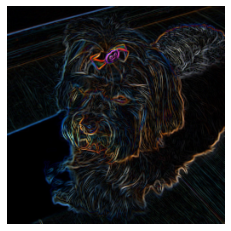

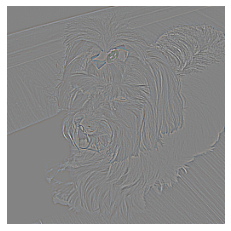

In [165]:
visualize_filter(image, gradient_filter)
visualize_filter(image, laplace_filter)

Visualizing the gradient and laplacian in the image **created by the network**

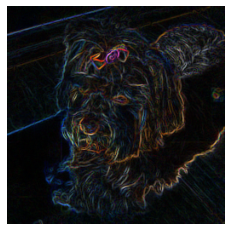

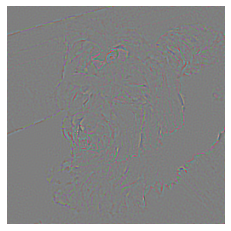

In [167]:
visualize_filter(decoded, gradient_filter)
visualize_filter(decoded, laplace_filter)